In [1]:
#import libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search for parameters tuning
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams # para graficar las variables más importantes para el modelo
from sklearn.cross_validation import train_test_split # para separar los data sets. 

In [2]:
#importar datos 
#link Data: https://www.kaggle.com/zhengjiaqin/analyse-hr-comma-sep-data/data
file= 'HR_comma_sep.csv'
datos=pd.read_csv(file,
                       header=0,
                       sep=',',
                       parse_dates=False,
                       skip_blank_lines=True)
datos.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
#tratar variables cualitativas
 # variable "salary"
datos['salary']=datos.salary.map({'low':1,'medium':2,'high':3})
 #variable "sales=area"
rh=datos.iloc[:,0:8]
temp=pd.get_dummies(datos['sales'])
temp1=datos.iloc[:,9:10]
datos=rh.join(temp).join(temp1)    
datos

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,salary
0,0.38,0.53,2,157,3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0.80,0.86,5,262,6,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
2,0.11,0.88,7,272,4,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
3,0.72,0.87,5,223,5,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,0.37,0.52,2,159,3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
5,0.41,0.50,2,153,3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
6,0.10,0.77,6,247,4,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
7,0.92,0.85,5,259,5,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
8,0.89,1.00,5,224,5,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
9,0.42,0.53,2,142,3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [4]:
%matplotlib inline

In [27]:
# define a function which will help us create GBM models and perform cross-validation. 

def modelfit(algorithm,datos, performCV=True, printFeatureImportance=True, cv_folds=5): #5 "pliegues" para CV
    
    #separar "x,y"
    Y=datos.iloc[:,6:7]
    X=datos.ix[:, datos.columns != 'left']
    
    #separar datos de entrenamiento y prueba
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)
    Y_train=np.array(Y_train)
            
    #Fit the algorithm on the training data
    algorithm.fit(X_train,Y_train)
        
    #Predict training set:
    dtrain_predictions = algorithm.predict(X_train)
    dtrain_predprob = algorithm.predict_proba(X_train)[:,1]
    
    #Perform cross-validation:
    if performCV:
        c, r = Y_train.shape
        Y_train = Y_train.reshape(c,)
        cv_score = cross_validation.cross_val_score(algorithm, X_train, Y_train, scoring='roc_auc',n_jobs=-1,cv=5) #using K-folds CV 
        cv_scoreR = cross_validation.cross_val_score(algorithm, X_train, Y_train, scoring='recall',n_jobs=-1,cv=5)
    
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)
    #Print model report:
    print ("\nModel Report")
    print ("Training Recall : %.4g" % metrics.recall_score(Y_train.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(Y_train, dtrain_predprob))
    
    if performCV:
        print ("CV Recall Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_scoreR),np.std(cv_scoreR),np.min(cv_scoreR),np.max(cv_scoreR)))
        print ("CV AUC Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        predictors=list(X_train.columns.values)
        feat_imp = pd.Series(algorithm.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    return X_train,Y_train

C:\Users\Edu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Training Recall : 0.9305
AUC Score (Train): 0.990317
CV Recall Score : Mean - 0.9265672 | Std - 0.0104072 | Min - 0.9171598 | Max - 0.9467456
CV AUC Score : Mean - 0.9880361 | Std - 0.002377026 | Min - 0.9860071 | Max - 0.9925562


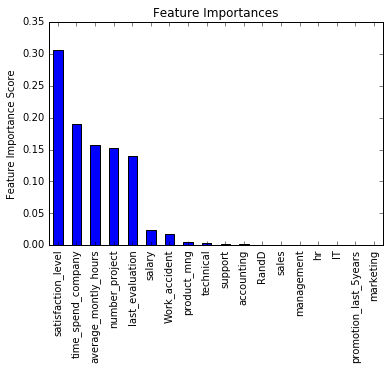

In [7]:
#baseline model (default parameters)

gbm0 = GradientBoostingClassifier(random_state=10) # default parameters
X_train,Y_train=modelfit(gbm0,datos)

In [8]:
#tuning paramaters with K-folds

#fijamos el learning rate en 0.1 y ajustamos el "número de árboles" 
param_test1 ={'n_estimators':[20,30,40,50,60,70,80]} # probamos 20,30,40...80 árboles 

min_samples_split=int(np.round(len(X_train)*.005)) # del .5 al 1% del número de observaciones 
min_samples_leaf=datos.left.sum()/len(datos)-.05 # fraccion de personas que han renunciado menos 5% 

gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=min_samples_split
,min_weight_fraction_leaf=min_samples_leaf,max_depth=5,max_features='sqrt',subsample=0.8,random_state=10)
,param_grid = param_test1, scoring='recall',n_jobs=-1,iid=False,cv=5)
# we fixex the learning rate to default "0.1" 

Y_train=np.array(Y_train)
c, r = Y_train.shape
Y_train = Y_train.reshape(c,)
gsearch1.fit(X_train,Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.07101, std: 0.05846, params: {'n_estimators': 20},
  mean: 0.42985, std: 0.08286, params: {'n_estimators': 30},
  mean: 0.67825, std: 0.01494, params: {'n_estimators': 40},
  mean: 0.70982, std: 0.02405, params: {'n_estimators': 50},
  mean: 0.74378, std: 0.02040, params: {'n_estimators': 60},
  mean: 0.77773, std: 0.02227, params: {'n_estimators': 70},
  mean: 0.79588, std: 0.02814, params: {'n_estimators': 80}],
 {'n_estimators': 80},
 0.7958821557483764)

In [17]:
min_samples_leaf

0.1880825388359224

In [16]:
#tuning paramaters with K-folds

# ajustamos la profundidad máxima y el número mínimo de muestras en nodo para split

param_test2 = {'max_depth':[5,6,7,8], 'min_samples_split':[52,63,73,84,94,105]}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_features='sqrt'
, subsample=0.8,min_weight_fraction_leaf=min_samples_leaf, random_state=10), param_grid = param_test2, scoring='recall',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train,Y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.79588, std: 0.02814, params: {'min_samples_split': 52, 'max_depth': 5},
  mean: 0.79588, std: 0.02814, params: {'min_samples_split': 63, 'max_depth': 5},
  mean: 0.79588, std: 0.02814, params: {'min_samples_split': 73, 'max_depth': 5},
  mean: 0.79588, std: 0.02814, params: {'min_samples_split': 84, 'max_depth': 5},
  mean: 0.79588, std: 0.02814, params: {'min_samples_split': 94, 'max_depth': 5},
  mean: 0.79588, std: 0.02814, params: {'min_samples_split': 105, 'max_depth': 5},
  mean: 0.79588, std: 0.02814, params: {'min_samples_split': 52, 'max_depth': 6},
  mean: 0.79588, std: 0.02814, params: {'min_samples_split': 63, 'max_depth': 6},
  mean: 0.79588, std: 0.02814, params: {'min_samples_split': 73, 'max_depth': 6},
  mean: 0.79588, std: 0.02814, params: {'min_samples_split': 84, 'max_depth': 6},
  mean: 0.79588, std: 0.02814, params: {'min_samples_split': 94, 'max_depth': 6},
  mean: 0.79588, std: 0.02814, params: {'min_samples_split': 105, 'max_depth': 6},
  mean: 0.7958

In [18]:
#tuning paramaters with K-folds

#ya que el "número mínimo de muestras en nodo para split" fue un valor en un extremo propuesto ampliaré la búsqueda hacia ese extremo
# ajustaremos el número mínimo de muestras por hoja(nodo final)

param_test3 = {'min_samples_split':[45,48,50,52], 'min_weight_fraction_leaf':[0.08,0.1,0.13,0.15,0.1880,0.2]}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=5,max_features='sqrt'
, subsample=0.8, random_state=10), param_grid = param_test3, scoring='recall',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train,Y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.90880, std: 0.00955, params: {'min_weight_fraction_leaf': 0.08, 'min_samples_split': 45},
  mean: 0.89735, std: 0.01124, params: {'min_weight_fraction_leaf': 0.1, 'min_samples_split': 45},
  mean: 0.88985, std: 0.01408, params: {'min_weight_fraction_leaf': 0.13, 'min_samples_split': 45},
  mean: 0.86813, std: 0.02665, params: {'min_weight_fraction_leaf': 0.15, 'min_samples_split': 45},
  mean: 0.79588, std: 0.02814, params: {'min_weight_fraction_leaf': 0.188, 'min_samples_split': 45},
  mean: 0.78128, std: 0.04435, params: {'min_weight_fraction_leaf': 0.2, 'min_samples_split': 45},
  mean: 0.90880, std: 0.00955, params: {'min_weight_fraction_leaf': 0.08, 'min_samples_split': 48},
  mean: 0.89735, std: 0.01124, params: {'min_weight_fraction_leaf': 0.1, 'min_samples_split': 48},
  mean: 0.88985, std: 0.01408, params: {'min_weight_fraction_leaf': 0.13, 'min_samples_split': 48},
  mean: 0.86813, std: 0.02665, params: {'min_weight_fraction_leaf': 0.15, 'min_samples_split': 48},
  

In [19]:
#tuning paramaters with K-folds

#vemos que el número mínimo de muestras para split no hizo diferencia por lo que lo fijamos en 52
# extenderemos la búsqueda para el "número mínimo de muestras en hojas.

param_test4 = {'min_weight_fraction_leaf':[.03,.05,0.08,0.1]}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=5,max_features='sqrt'
, subsample=0.8,min_samples_split=52, random_state=10), param_grid = param_test4, scoring='recall',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train,Y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.91472, std: 0.01308, params: {'min_weight_fraction_leaf': 0.03},
  mean: 0.90880, std: 0.01388, params: {'min_weight_fraction_leaf': 0.05},
  mean: 0.90880, std: 0.00955, params: {'min_weight_fraction_leaf': 0.08},
  mean: 0.89735, std: 0.01124, params: {'min_weight_fraction_leaf': 0.1}],
 {'min_weight_fraction_leaf': 0.03},
 0.91472117625963778)

C:\Users\Edu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Training Recall : 0.9179
AUC Score (Train): 0.988393
CV Recall Score : Mean - 0.9147212 | Std - 0.01307916 | Min - 0.9013807 | Max - 0.938856
CV AUC Score : Mean - 0.9853922 | Std - 0.002962712 | Min - 0.9816236 | Max - 0.9906791


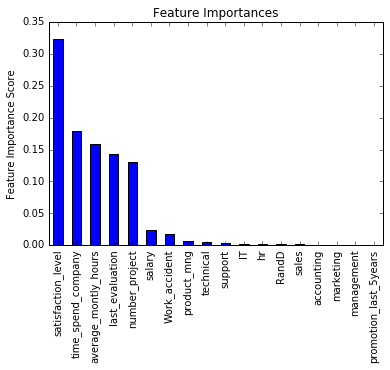

In [21]:
#Let’s fit the model again on this and have a look at the feature importance.
x_train,y_train=modelfit(gsearch4.best_estimator_,datos)

In [25]:
#tuning paramaters with K-folds

#ajustamos por último "max_features" 

param_test5 = {'max_features':[4,5,6,7,8,9,10]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=5, min_samples_split=52,
min_weight_fraction_leaf=.03, subsample=0.8, random_state=10),
param_grid = param_test5, scoring='recall',n_jobs=-1,iid=False, cv=5)

gsearch5.fit(X_train,Y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.91472, std: 0.01308, params: {'max_features': 4},
  mean: 0.91591, std: 0.01240, params: {'max_features': 5},
  mean: 0.91591, std: 0.01277, params: {'max_features': 6},
  mean: 0.91512, std: 0.01109, params: {'max_features': 7},
  mean: 0.91709, std: 0.00992, params: {'max_features': 8},
  mean: 0.91551, std: 0.01056, params: {'max_features': 9},
  mean: 0.91630, std: 0.01201, params: {'max_features': 10}],
 {'max_features': 8},
 0.91709193816217227)

In [26]:
#tuning paramaters with K-folds

#ajustamos finalmente el "subsample"
param_test6 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch6 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=5, min_samples_split=52,
min_weight_fraction_leaf=.03, max_features=8, random_state=10),
param_grid = param_test6, scoring='recall',n_jobs=-1,iid=False, cv=5)

gsearch6.fit(X_train,Y_train)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_


([mean: 0.91709, std: 0.01082, params: {'subsample': 0.6},
  mean: 0.91670, std: 0.01077, params: {'subsample': 0.7},
  mean: 0.91709, std: 0.01146, params: {'subsample': 0.75},
  mean: 0.91709, std: 0.00992, params: {'subsample': 0.8},
  mean: 0.91630, std: 0.01093, params: {'subsample': 0.85},
  mean: 0.91551, std: 0.01113, params: {'subsample': 0.9}],
 {'subsample': 0.6},
 0.91709271776161416)

In [31]:
def modelfit1(algorithm,datos, performCV=True, printFeatureImportance=True, cv_folds=5): #5 "pliegues" para CV
    
    #separar "x,y"
    Y=datos.iloc[:,6:7]
    X=datos.ix[:, datos.columns != 'left']
    
    #separar datos de entrenamiento y prueba
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)
    Y_train=np.array(Y_train)
            
    #Fit the algorithm on the training data
    algorithm.fit(X_train,Y_train)
        
    #Predict test set:
    dtest_predictions = algorithm.predict(X_test)
    dtest_predprob = algorithm.predict_proba(X_test)[:,1]
    
    #Perform cross-validation:
    if performCV:
        c, r = Y_train.shape
        Y_train = Y_train.reshape(c,)
        cv_score = cross_validation.cross_val_score(algorithm, X_train, Y_train, scoring='roc_auc',n_jobs=-1,cv=5) #using K-folds CV 
        cv_scoreR = cross_validation.cross_val_score(algorithm, X_train, Y_train, scoring='recall',n_jobs=-1,cv=5)
    
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)
    #Print model report:
    print ("\nModel Report")
    print ("Test Recall : %.4g" % metrics.recall_score(Y_test.values, dtest_predictions))
    print ("AUC Score (Test): %f" % metrics.roc_auc_score(Y_test, dtest_predprob))
    
    if performCV:
        print ("CV Recall Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_scoreR),np.std(cv_scoreR),np.min(cv_scoreR),np.max(cv_scoreR)))
        print ("CV AUC Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        predictors=list(X_train.columns.values)
        feat_imp = pd.Series(algorithm.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    return X_test,Y_test

C:\Users\Edu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Test Recall : 0.9171
AUC Score (Test): 0.987947
CV Recall Score : Mean - 0.9170935 | Std - 0.01150746 | Min - 0.9013807 | Max - 0.9368836
CV AUC Score : Mean - 0.9876857 | Std - 0.002790662 | Min - 0.9838249 | Max - 0.9923383


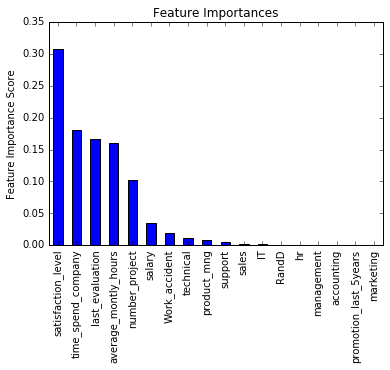

In [32]:
# ya que tenemos ajustados todos los parámetros, aumentamos el número de árboles y reducimos el "learning rate"

gbm_tuned = GradientBoostingClassifier(learning_rate=0.05, n_estimators=160,max_depth=5, min_samples_split=52
,min_weight_fraction_leaf=0.03, subsample=0.8, random_state=10, max_features=8)

X_test,Y_test=modelfit1(gbm_tuned,datos)

C:\Users\Edu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Test Recall : 0.9316
AUC Score (Test): 0.992103
CV Recall Score : Mean - 0.9289372 | Std - 0.01109456 | Min - 0.9171598 | Max - 0.9487179
CV AUC Score : Mean - 0.9919179 | Std - 0.002236104 | Min - 0.9890516 | Max - 0.9953557


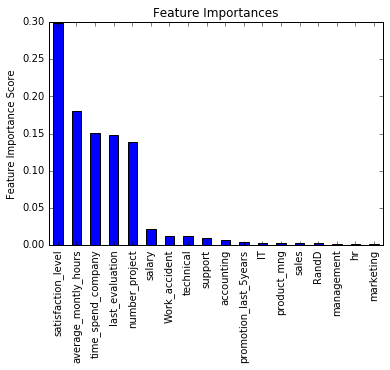

In [33]:
# ya que tenemos ajustados todos los parámetros, aumentamos el número de árboles y reducimos el "learning rate"
# cambiamos el número mínimo de muestras en hojas a 1 para ver si mejora el resultado

gbm_tuned1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=160,max_depth=5, min_samples_split=52
,min_weight_fraction_leaf=0, subsample=0.8, random_state=10, max_features=8)

X_test,Y_test=modelfit1(gbm_tuned1,datos)